# NOAA 1158: Power-law Heating Model
Setup a heating model whose frequency is determined entirely by selections from a power-law selection rather than by a prescribed frequency or ratio of cooling times.

In [193]:
import os
import logging
import warnings
import multiprocessing
import subprocess
import random
warnings.filterwarnings('ignore')

import numpy as np
from sunpy.map import Map,GenericMap
import astropy.units as u
import astropy.constants as const
import matplotlib.pyplot as plt
import matplotlib
import dask.distributed

import synthesizAR
from synthesizAR.model_ext import EbtelInterface
from synthesizAR.instruments import InstrumentSDOAIA

%matplotlib inline

In [ ]:
client = dask.distributed.Client()
client

## Power-law Heating Model

In [3]:
class NewPowerLawHeatingModel(object):
    def __init__(self,heating_options):
        self.heating_options = heating_options
        self.logger = logging.getLogger(name=type(self).__name__)
        
    def calculate_event_properties(self,loop):
        energies = self.event_energies(loop)
        rates = energies/(self.heating_options['duration'] - 0.5*(self.heating_options['duration_rise']
                                                                  +self.heating_options['duration_decay']))
        delays = self.base_config['total_time']*energies/self.strand_energy(loop)
        self.number_events = rates.shape[0]
        # randomly distribute delays over an interval that depends on the number of events
        delays = np.random.uniform(1.0 - 1.0/self.number_events,1.0)*delays
        running_total = 0.0
        rise_start = np.empty(rates.shape)
        for i in range(self.number_events):
            running_total += delays[i]
            rise_start[i] = running_total
        
        rise_end = rise_start+self.heating_options['duration_rise']
        decay_start = rise_end+(self.heating_options['duration']-self.heating_options['duration_rise']
                                -self.heating_options['duration_decay'])
        return {'magnitude':rates,'rise_start':rise_start,'rise_end':rise_end,
                'decay_start':decay_start,'decay_end':rise_start+self.heating_options['duration']}
    
    def event_energies(self,loop):
        sample = self.power_law(*self.heating_options['power_law_bounds'],self.heating_options['power_law_slope'],
                                np.random.rand(int(1e4)))
        i_stop = np.where(sample.cumsum()>=self.strand_energy(loop))[0][0]
        sample = sample[:i_stop]
        sample = np.append(sample,self.strand_energy(loop) - sample.sum())
        return np.random.permutation(sample)
    
    def strand_energy(self,loop):
        return ((self.heating_options['stress_level']*loop.field_strength.value.mean())**2)/8./np.pi
    
    @staticmethod
    def power_law(a0,a1,alpha,x):
        return ((a1**(alpha + 1.) - a0**(alpha + 1.))*x + a0**(alpha + 1.))**(1./(alpha + 1.))

In [6]:
def cooling_time(loop,strand_energy,duration):
    half_length = loop.full_length.value/2.
    average_heating_rate_max = strand_energy/(duration/2.)#*u.erg/(u.cm**3)/u.s
    # set some constants
    alpha = -0.5
    chi = 6e-20#*(u.erg*(u.cm**3)/u.s*u.K**(0.5))
    kappa_0 = 1e-6#*(u.erg/u.cm/u.s*(u.K**(-7/2)))
    c1,c2,c3 = 2.0,0.9,0.6
    gamma = 5./3.
    # estimate max n0T0
    T0 = c2*(7.*half_length**2*average_heating_rate_max/2./kappa_0)**(2./7.)
    top_term = average_heating_rate_max - 2.*kappa_0*(T0**(3.5))/(7.*(c2**2.5)*c3*(half_length**2)*gamma)
    bottom_term = c1*chi*(T0**alpha)*(1. - c2/c3/gamma)
    n0 = np.sqrt(top_term/bottom_term)
    n0T0 = n0*T0
    # Cargill cooling expression
    term1 = (2. - alpha)/(1. - alpha)
    term2 = (kappa_0**(4. - 2.*alpha))*(chi**7)
    term3 = ((half_length)**(8. - 4.*alpha))/(n0T0**(3+2.*alpha))
    return term1*3.*const.k_B.cgs.value*(1/term2*term3)**(1/(11. - 2.*alpha))

## Sandbox

In [366]:
stress_level = 0.1
freq_param = 0.1
total_time = 3e4
strand_cross_section = 1e14
def max_event_energy(loop):
    return ((stress_level*loop.field_strength.max().value)**2)/8/np.pi
tau_cool = np.array([cooling_time(loop,max_event_energy(loop),200.) for loop in field.loops])
number_of_events = np.floor(total_time/freq_param/tau_cool + 1)

We could just find the area of the whole AR and then estimate the loop cross-section for a single value.

In [344]:
ar_area = (field._convert_angle_to_length(field.hmi_map.dimensions.x*field.hmi_map.scale.x)
           *field._convert_angle_to_length(field.hmi_map.dimensions.y*field.hmi_map.scale.y))

In [345]:
ar_total_max = (np.array([max_event_energy(loop)*loop.full_length.value*strand_cross_section for loop in field.loops])
                *number_of_events).sum()/total_time/ar_area

In [346]:
print('{:g}'.format(ar_total_max))##/ar_area.value))

1.13682e+08 1 / cm2


Or we could estimate the loop cross section for each strand by looking at the concentration of strands across the AR.

In [347]:
# Choose only one footpoint
footpoints = []
for loop in field.loops:
    footpoints.append(loop.coordinates[0][:2].value)
    #footpoints.append(loop.coordinates[-1][:2].value)

In [348]:
bin_range = (field._convert_angle_to_length(field.clipped_hmi_map.xrange).value,
             field._convert_angle_to_length(field.clipped_hmi_map.yrange).value)
bins = (field.clipped_hmi_map.dimensions.x.value,field.clipped_hmi_map.dimensions.y.value)

In [349]:
fp_dist,edges = np.histogramdd(np.array(footpoints),bins=bins,range=bin_range)

In [350]:
area_per_pixel = (field._convert_angle_to_length(field.clipped_hmi_map.scale.x*1*u.pixel)
                  *field._convert_angle_to_length(field.clipped_hmi_map.scale.y*1*u.pixel)).value

In [351]:
cross_section_map = GenericMap(np.where(fp_dist==0,np.nan,area_per_pixel/fp_dist).T,
                               field.clipped_hmi_map.meta.copy())

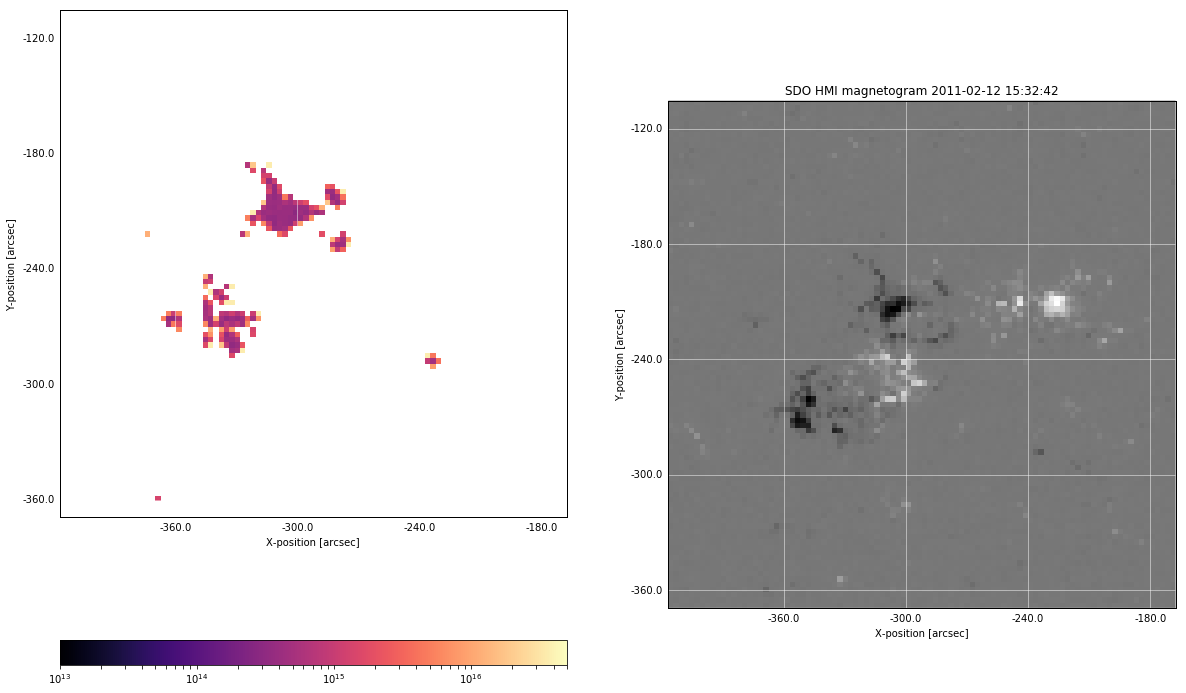

In [352]:
fig = plt.figure(figsize=(20,15))
ax1 = fig.add_subplot(121,projection=cross_section_map)
im = cross_section_map.plot(axes=ax1,
                            cmap=plt.get_cmap('magma'),
                            title=False,
                            norm=matplotlib.colors.SymLogNorm(0.1,vmin=1e13,vmax=5e16))
ax2 = fig.add_subplot(122,projection=field.clipped_hmi_map)
field.clipped_hmi_map.plot(axes=ax2)
fig.colorbar(im,ax=ax1,orientation='horizontal')
#plt.tight_layout()

In [367]:
ix = np.digitize(np.array(footpoints)[:,0],edges[0])-1
iy = np.digitize(np.array(footpoints)[:,1],edges[1])-1

In [371]:
ar_total_max = (np.array([max_event_energy(loop)*loop.full_length.value 
                          for loop,cs in zip(field.loops, cross_section_map.data[iy,ix])])
                *number_of_events).sum()/total_time

In [372]:
print('{:g}'.format(ar_total_max))##/ar_area.value))

3.34772e+13


## Active Region Setup
First, we need to take a look at the field and figure out the appropriate bounds on our power-law distribution based on the amount of estimated non-potential energy stored in the field.

Load the base field.

In [5]:
field = synthesizAR.Skeleton.restore('../../../data/base_noaa1158/')

No HMI fits file supplied. A new HMI map object will not be created.
yt : [INFO     ] 2017-09-26 18:59:54,606 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-09-26 18:59:54,607 Parameters: domain_dimensions         = [95 96 96]
yt : [INFO     ] 2017-09-26 18:59:54,608 Parameters: domain_left_edge          = [ -2.96081016e+10  -2.62091384e+10   3.91869796e+08]
yt : [INFO     ] 2017-09-26 18:59:54,609 Parameters: domain_right_edge         = [ -1.18463315e+10  -7.41270210e+09   1.92016200e+10]
yt : [INFO     ] 2017-09-26 18:59:54,610 Parameters: cosmological_simulation   = 0.0


In [ ]:
for loop in field.loops[::100]:
    plt.plot(loop.field_aligned_coordinate[:]/loop.field_aligned_coordinate.max(),
             loop.field_strength[:],'r',alpha=0.1)
plt.yscale('log')

In [ ]:
params = {'histtype':'step','lw':2,'bins':'fd','color':'b','alpha':0.01,'normed':False}
for loop in field.loops[::1]:
    upper_bound = (loop.field_strength.max().value*0.3)**2/8/np.pi
    lower_bound = (loop.field_strength[1:].min().value*0.3)**2/8/np.pi
    pl = NewPowerLawHeatingModel.power_law(lower_bound,upper_bound,-1.5,np.random.rand(int(1e4)))
    plt.hist(pl/100.,**params)
plt.xscale('log')
plt.yscale('log')

Setup heating options and model.

In [ ]:
base_heating_options = {
    'duration':200.0,
    'duration_rise':100.0,
    'duration_decay':100.0,
    'stress_level':0.1,
}

The biggest question really is what should the bounds be on our power-law distribution? We want to sample the same distribution for each strand so we need a lower bound that doesn't give too many low energy events. The upper bound is not so important.

In [ ]:
tmp = NewPowerLawHeatingModel(base_heating_options)

In [ ]:
strand_energies = np.array([tmp.strand_energy(loop) for loop in field.loops])

In [ ]:
plt.hist(strand_energies,bins=np.logspace(-2,2,50),histtype='step',lw=2);
plt.axvline(x=strand_energies.mean(),c='k')
plt.axvline(x=strand_energies.mean()+strand_energies.std(),c='k',ls='--')
plt.axvline(x=strand_energies.mean()-strand_energies.std(),c='k',ls='--')
plt.xscale('log')

In [ ]:
a0 = strand_energies.mean()-strand_energies.std()
a1 = strand_energies.mean()+strand_energies.std()

Now, set the bounds appropriately for the base heating model configuration.

In [ ]:
base_heating_options['power_law_bounds'] = (a0,a1)

Additionally, set up the base EBTEL configuration

In [ ]:
ih = synthesizAR.util.InputHandler('/storage-home/w/wtb2/codes/ebtelPlusPlus/config/ebtel.example.cfg.xml')
base_config = ih.lookup_vars()
base_config['c1_cond0'] = 6.0
base_config['total_time'] = 3e4
base_config['use_adaptive_solver'] = True
base_config['use_flux_limiting'] = True
base_config['calculate_dem'] = False
base_config['heating']['partition'] = 1.0
base_config['heating']['background'] = 1e-6
base_config['force_single_fluid'] = False
base_config['tau_max'] = 200.0

### $\alpha=-1.5$

In [ ]:
field_alpha15 = synthesizAR.Skeleton.restore('../../../data/base_noaa1158/')

In [ ]:
heating_options = base_heating_options.copy()
heating_options['power_law_slope'] = -1.5
heating_model = NewPowerLawHeatingModel(heating_options)
ebtel_interface = EbtelInterface(base_config.copy(),heating_model,
                                 '/storage-home/w/wtb2/data/noaa1158_powerlaw_alpha15/hydro_config/',
                                 '/storage-home/w/wtb2/data/noaa1158_powerlaw_alpha15/hydro_results/')

In [ ]:
energy_distribution = heating_model.power_law(a0,a1,heating_options['power_law_slope'],np.random.rand(int(1e5)))
plt.hist(energy_distribution,bins=np.logspace(np.log10(a0),np.log10(a1),100),log=True,histtype='step',lw=2);
plt.xscale('log')
plt.ylim([100,5e3])

In [ ]:
number_events = np.array([np.where(energy_distribution.cumsum()>=heating_model.strand_energy(loop))[0][0] 
                          for loop in field_alpha15.loops])
plt.hist(number_events,bins='fd',log=True,histtype='step',lw=2);

Configure the models and run them

In [ ]:
field_alpha15.configure_loop_simulations(ebtel_interface)

In [ ]:
def ebtel_runner(loop):
    subprocess.call([os.path.join('/storage-home/w/wtb2/codes/','ebtelPlusPlus/bin/ebtel++.run'),
                     '-c',loop.hydro_configuration['config_filename']])

In [ ]:
pool = multiprocessing.Pool()

In [ ]:
runs = pool.map_async(ebtel_runner,field_alpha15.loops)
runs.wait()

And load the results back into the field.

In [ ]:
field_alpha15.load_loop_simulations(ebtel_interface,'/storage-home/w/wtb2/data/noaa1158_powerlaw_alpha15/loop_parameters.h5')

Finally, peek at the hydrodynamic results.

In [ ]:
fig,axes = plt.subplots(2,1,figsize=(20,10),sharex=True)
plt.subplots_adjust(hspace=0.)
for loop in np.array(field_alpha15.loops)[::500]:
    axes[0].plot(loop.time,loop.electron_temperature[:,0].to(u.MK),color='b',alpha=0.5)
    #axes[0].plot(loop.time,loop.ion_temperature[:,0].to(u.MK),color='r',alpha=0.5)
    axes[1].plot(loop.time,loop.density[:,0]/1e9,color='b',alpha=0.5)
axes[0].set_xlim([0,3e4])#base_config['total_time']])
#axes[0].set_ylim([0,10])
#axes[1].set_ylim([0,10])
axes[0].set_ylabel(r'$T$ [MK]')
axes[1].set_ylabel(r'$n$ [10$^9$ cm$^{-3}$]')
axes[1].set_xlabel(r'$t$ [s]')

And save the field.

In [ ]:
field_alpha15.save('/storage-home/w/wtb2/data/noaa1158_powerlaw_alpha15/field_checkpoint')

Now restore the field.

In [ ]:
field_alpha15 = synthesizAR.Skeleton.restore('/storage-home/w/wtb2/data/noaa1158_powerlaw_alpha15/field_checkpoint/')

Next, peforme the flattening and binning to create the instrument data products. Setup instrument and observer.

In [ ]:
aia = InstrumentSDOAIA([1e4,2e4]*u.s)

In [ ]:
observer = synthesizAR.Observer(field_alpha15,[aia])

In [ ]:
observer.build_detector_files('/storage-home/w/wtb2/data/noaa1158_powerlaw_alpha15/',
                              ds=field_alpha15._convert_angle_to_length(1.2*u.arcsec))

Construct DAGs for both the flattening and binning steps. These are then passed to the distributed scheduler so they can be run.

In [ ]:
flatten_dag = observer.flatten_detector_counts()

In [ ]:
flatten_dag['SDO_AIA'].compute(resources={'MEMORY':'64GB'})

In [ ]:
bin_dag = observer.bin_detector_counts('/storage-home/w/wtb2/data/noaa1158_powerlaw_alpha15')

In [ ]:
jobs = client.compute(bin_dag['SDO_AIA'])

### $\alpha=-2$

### $\alpha=-2.5$